# Overview

The purpose of this notebook was to experiment with creating spatial plots. All of this usage was making use of the ``cholla_vis.sample_plot`` functionality.

In [1]:
%%time
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from cholla_vis import sample_plot
from cholla_vis.registry import get_simdata_registry

/Users/mabruzzo/Dropbox/research/mw-wind/cholla-vis/src/cholla_vis/sample_plot.py:181: SyntaxWarning: invalid escape sequence '\l'
  prefix = r'$\log_{10} ('


CPU times: user 390 ms, sys: 71.3 ms, total: 462 ms
Wall time: 798 ms


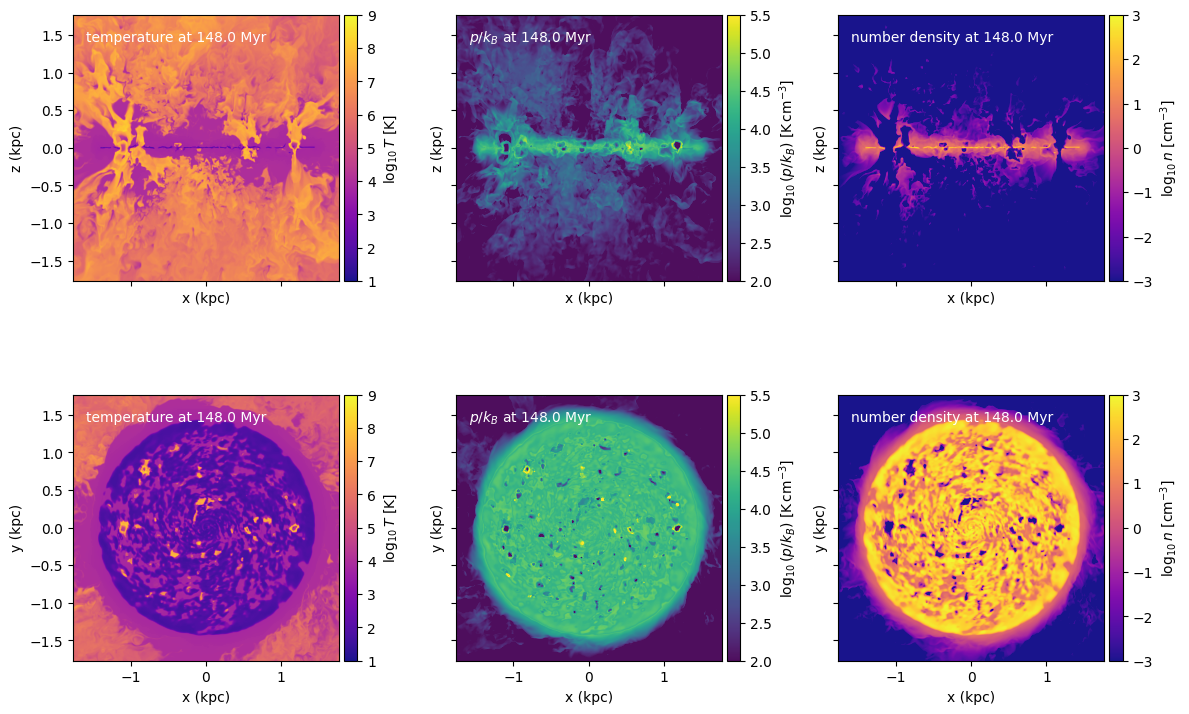

In [15]:
def _plot(sim_name, snap, override_fn = None, orientation = 'xz', fig = None, ax_arr = None):
    registry = get_simdata_registry()
    sim_dir = f'{registry[sim_name]}/raw/'

    plot_proj = False

    kwargs = {
        'dnamein' : f'{sim_dir}/{snap}/',
        'load_distributed_files' : True,
        'n' : snap,
        'orientation' : orientation,
        'plot_proj' : plot_proj,
    }

    if False:
        sample_plot.make_slice_plot(
            preset_name = "vrot",
            #particle_selector = sample_plot.ParticleSelector(age_based = True),
            **kwargs);
        return None, None
    elif override_fn is not None:
        fig,ax_arr = plt.subplots(1,1, figsize= (8,8), squeeze=False,
                                  sharex=True, sharey=True)
        sample_plot.make_slice_panel(
            fig, ax_arr[0,0], preset_name = None, override_fn=override_fn,
            **kwargs
        )
        return fig, ax_arr
    else:
        if ax_arr is None:
            assert fig is None
            fig,ax_arr = plt.subplots(2,3, figsize= (12,8), sharex=True, sharey='row')
        else:
            assert fig is not None

        for i,preset_name in enumerate(["temperature", "phat", "ndens"]):
            ax = ax_arr.flatten()[i]
            sample_plot.make_slice_panel(
                fig, ax, preset_name = preset_name,
                **kwargs
            )
        return fig, ax_arr

fig,ax_arr = plt.subplots(2,3, figsize= (12,8), sharex=True, sharey='row')

_plot('708cube_GasStaticG-1Einj_restart-TIcool', 1480, fig = fig, ax_arr=ax_arr[0,:])
_plot('708cube_GasStaticG-1Einj_restart-TIcool', 1480, fig = fig, ax_arr=ax_arr[1,:],
      orientation = 'xy')
fig.tight_layout()
plt.savefig('sample-slice-set.png')

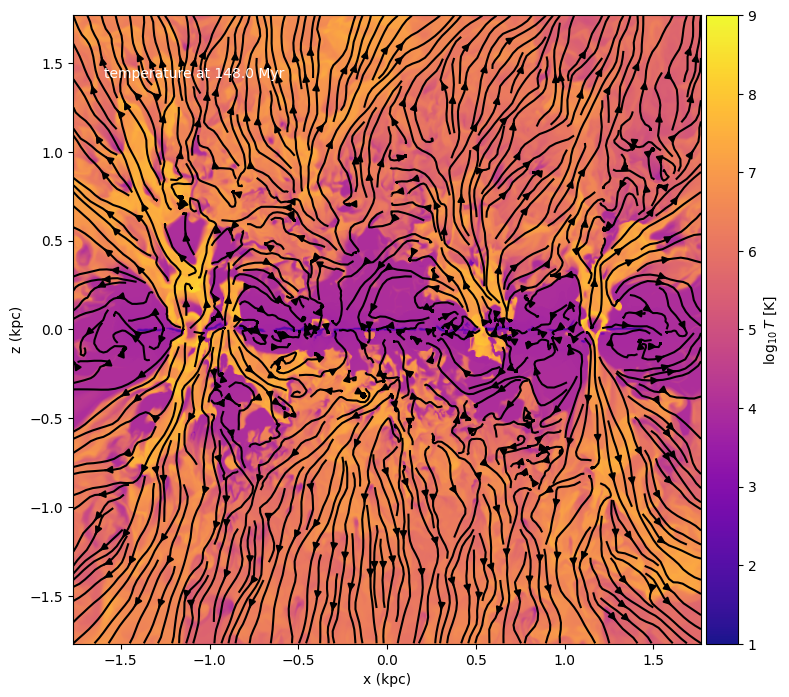

In [17]:
from functools import partial

def override_fn(ax, slc_dset, orientation, u_obj, domain_dims, **kwargs):
    assert orientation in ('xy', 'xz', 'yz')

    x, y, z = sample_plot._get_xyz(
        slc_dset, orientation, u_obj, domain_dims
    )
    tmp = {'x' : x, 'y' : y, 'z' : z}

    # vector component 0 (1) is aligned with plot's x-axis (y-axis)
    pos0 = tmp[orientation[0]]
    pos1 = tmp[orientation[1]]

    v0 = sample_plot._get_vcomp_km_per_s(
        slc_dset, axis=orientation[0], suffix=orientation, unit_obj=u_obj
    )
    v1 = sample_plot._get_vcomp_km_per_s(
        slc_dset, axis=orientation[1], suffix=orientation, unit_obj=u_obj
    )

    local_kwargs = dict(pair for pair in kwargs.items() if pair[0] != 'extent')

    out = ax.streamplot(
        x = pos0.T, y = pos1.T, u = v0.T, v = v1.T,
        **local_kwargs
    )

    sample_plot._add_ax_labels(ax, orientation)

    return out

def _plot2(sim_name, snap, override_fn = None, orientation = 'xz'):
    registry = get_simdata_registry()
    sim_dir = f'{registry[sim_name]}/raw/'

    plot_proj = False

    kwargs = {
        'dnamein' : f'{sim_dir}/{snap}/',
        'load_distributed_files' : True,
        'n' : snap,
        'orientation' : orientation,
        'plot_proj' : plot_proj,
    }

    fig,ax_arr = plt.subplots(1,1, figsize=(8,8),squeeze=False)

    sample_plot.make_slice_panel(
        fig, ax_arr[0,0], preset_name = 'temperature',
        **kwargs
    )

    my_override = partial(
        override_fn,
        density=3,
        color='k',
        #arrowstyle='-'
    )
    sample_plot.make_slice_panel(
        fig, ax_arr[0,0], preset_name = None, override_fn=my_override,
        **kwargs
    )
    return fig,ax_arr
    

fig, _ = _plot2('708cube_GasStaticG-1Einj_restart-TIcool', 1480,
               override_fn=override_fn, orientation = 'xz')
fig.tight_layout()
plt.savefig('sample-streamline.png')
#fig, _ = _plot2('708cube_GasStaticG-2Einj_restart-TIcool', 1481,
#               override_fn=override_fn, orientation = 'xz')
#fig.tight_layout()